# Ejercicio 3: Previsión de Falla - Resumen Completo

## Introducción

Este notebook presenta un resumen completo del análisis realizado para el **Ejercicio 3: Previsión de Falla** del desafío de Data Science de Mercado Libre. El objetivo principal es desarrollar un sistema de mantenimiento predictivo para dispositivos en galpones de Full, utilizando técnicas de machine learning para predecir fallas antes de que ocurran.

### Contexto del Problema
- Los galpones de Full de Mercado Libre cuentan con una flota de dispositivos que transmiten diariamente telemetría agregada
- Las técnicas de mantenimiento predictivo están diseñadas para determinar la condición del equipo y predecir cuándo se debe realizar el mantenimiento
- Este enfoque promete ahorros de costos sobre el mantenimiento preventivo de rutina

### Estructura del Análisis
1. **Análisis Exploratorio de Datos (EDA)**
2. **Feature Engineering**
3. **Construcción y Evaluación de Modelos**
4. **Resultados y Conclusiones**

In [1]:
# Configuración y librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Análisis Exploratorio de Datos (EDA)

### 1.1 Descripción del Dataset

In [2]:
# Cargar datos
df_devices = pd.read_csv('../../data/00_raw/full_devices.csv', encoding="latin1")

print("=== INFORMACIÓN DEL DATASET ===")
print(f"Tamaño del dataset: {len(df_devices):,} registros")
print(f"Período temporal: {df_devices['date'].min()} a {df_devices['date'].max()}")
print(f"Dispositivos únicos: {df_devices['device'].nunique():,}")
print(f"Variables: {len(df_devices.columns)} columnas")
print("\n=== TIPOS DE DATOS ===")
print(df_devices.dtypes.value_counts())
print("\n=== PRIMERAS FILAS ===")
df_devices.head()

=== INFORMACIÓN DEL DATASET ===
Tamaño del dataset: 124,494 registros
Período temporal: 2015-01-01 a 2015-11-02
Dispositivos únicos: 1,169
Variables: 12 columnas

=== TIPOS DE DATOS ===
int64     10
object     2
Name: count, dtype: int64

=== PRIMERAS FILAS ===


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [3]:
# Verificar valores nulos
print("=== ANÁLISIS DE VALORES NULOS ===")
null_counts = df_devices.isnull().sum()
print(null_counts[null_counts > 0] if null_counts.sum() > 0 else "✅ No hay valores nulos")

print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
df_devices.describe()

=== ANÁLISIS DE VALORES NULOS ===
✅ No hay valores nulos

=== ESTADÍSTICAS DESCRIPTIVAS ===


,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,0.001,122388103.242,159.485,9.940,1.741,14.223,260172.658,0.293,0.293,12.452
std,0.029,70459334.216,2179.658,185.747,22.909,15.943,99151.079,7.437,7.437,191.426
min,0.000,0.000,0.000,0.000,0.000,1.000,8.000,0.000,0.000,0.000
25%,0.000,61284762.000,0.000,0.000,0.000,8.000,221452.000,0.000,0.000,0.000
50%,0.000,122797388.000,0.000,0.000,0.000,10.000,249799.500,0.000,0.000,0.000
75%,0.000,183309640.000,0.000,0.000,0.000,12.000,310266.000,0.000,0.000,0.000
max,1.000,244140480.000,64968.000,24929.000,1666.000,98.000,689161.000,832.000,832.000,18701.000


### 1.2 Análisis del Desbalance de Clases

=== ANÁLISIS DE FALLAS ===
Total de registros: 124,494
Registros con fallas: 106 (0.085%)
Registros sin fallas: 124,388 (99.915%)
Dispositivos con fallas: 106
Dispositivos totales: 1,169


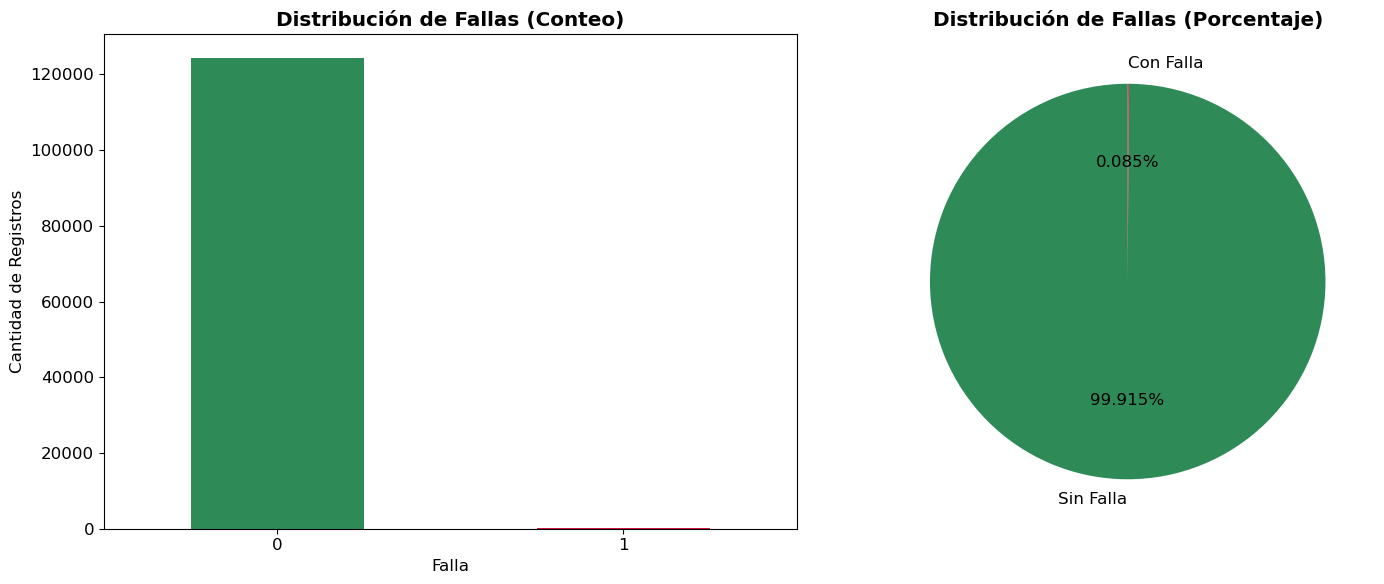

In [4]:
# Análisis del desbalance
failure_counts = df_devices['failure'].value_counts()
failure_pct = df_devices['failure'].value_counts(normalize=True) * 100

print("=== ANÁLISIS DE FALLAS ===")
print(f"Total de registros: {len(df_devices):,}")
print(f"Registros con fallas: {failure_counts[1]:,} ({failure_pct[1]:.3f}%)")
print(f"Registros sin fallas: {failure_counts[0]:,} ({failure_pct[0]:.3f}%)")
print(f"Dispositivos con fallas: {df_devices[df_devices['failure']==1]['device'].nunique():,}")
print(f"Dispositivos totales: {df_devices['device'].nunique():,}")

# Visualización del desbalance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
failure_counts.plot(kind='bar', ax=ax1, color=['#2E8B57', '#DC143C'])
ax1.set_title('Distribución de Fallas (Conteo)', fontweight='bold')
ax1.set_xlabel('Falla')
ax1.set_ylabel('Cantidad de Registros')
ax1.tick_params(axis='x', rotation=0)

# Gráfico de torta
ax2.pie(failure_counts.values, labels=['Sin Falla', 'Con Falla'], 
       autopct='%1.3f%%', colors=['#2E8B57', '#DC143C'], startangle=90)
ax2.set_title('Distribución de Fallas (Porcentaje)', fontweight='bold')

plt.tight_layout()
plt.show()

### 1.3 Análisis de Correlaciones

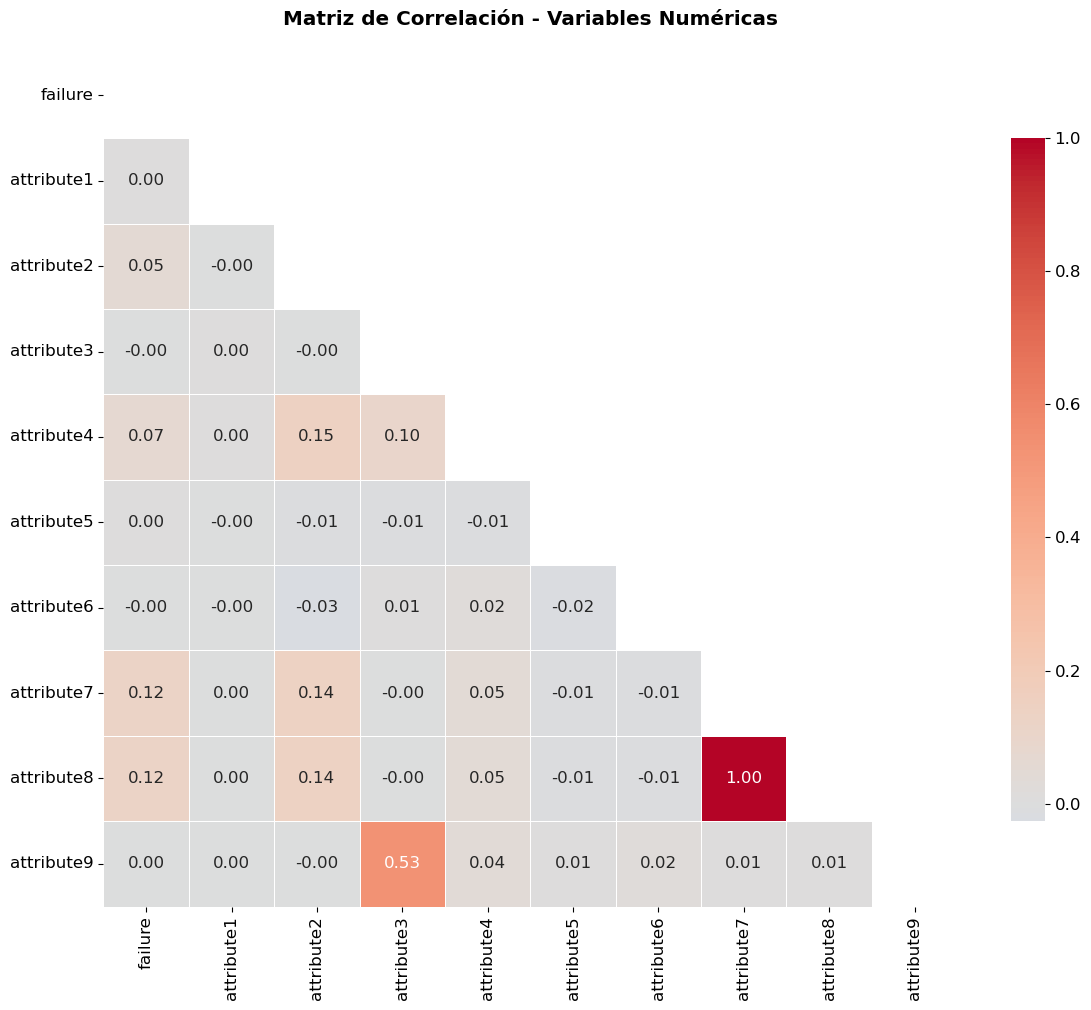

=== CORRELACIONES ALTAS (>0.8) ===
attribute7 - attribute8: 1.000


In [5]:
# Matriz de correlación
corr = df_devices.corr(numeric_only=True)

# Crear heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación - Variables Numéricas', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Identificar correlaciones altas
print("=== CORRELACIONES ALTAS (>0.8) ===")
high_corr = np.where(np.abs(corr) > 0.8)
high_corr = [(corr.index[x], corr.columns[y], corr.iloc[x, y]) 
            for x, y in zip(*high_corr) if x != y and x < y]
for var1, var2, corr_val in high_corr:
    print(f"{var1} - {var2}: {corr_val:.3f}")

### 1.4 Análisis Temporal

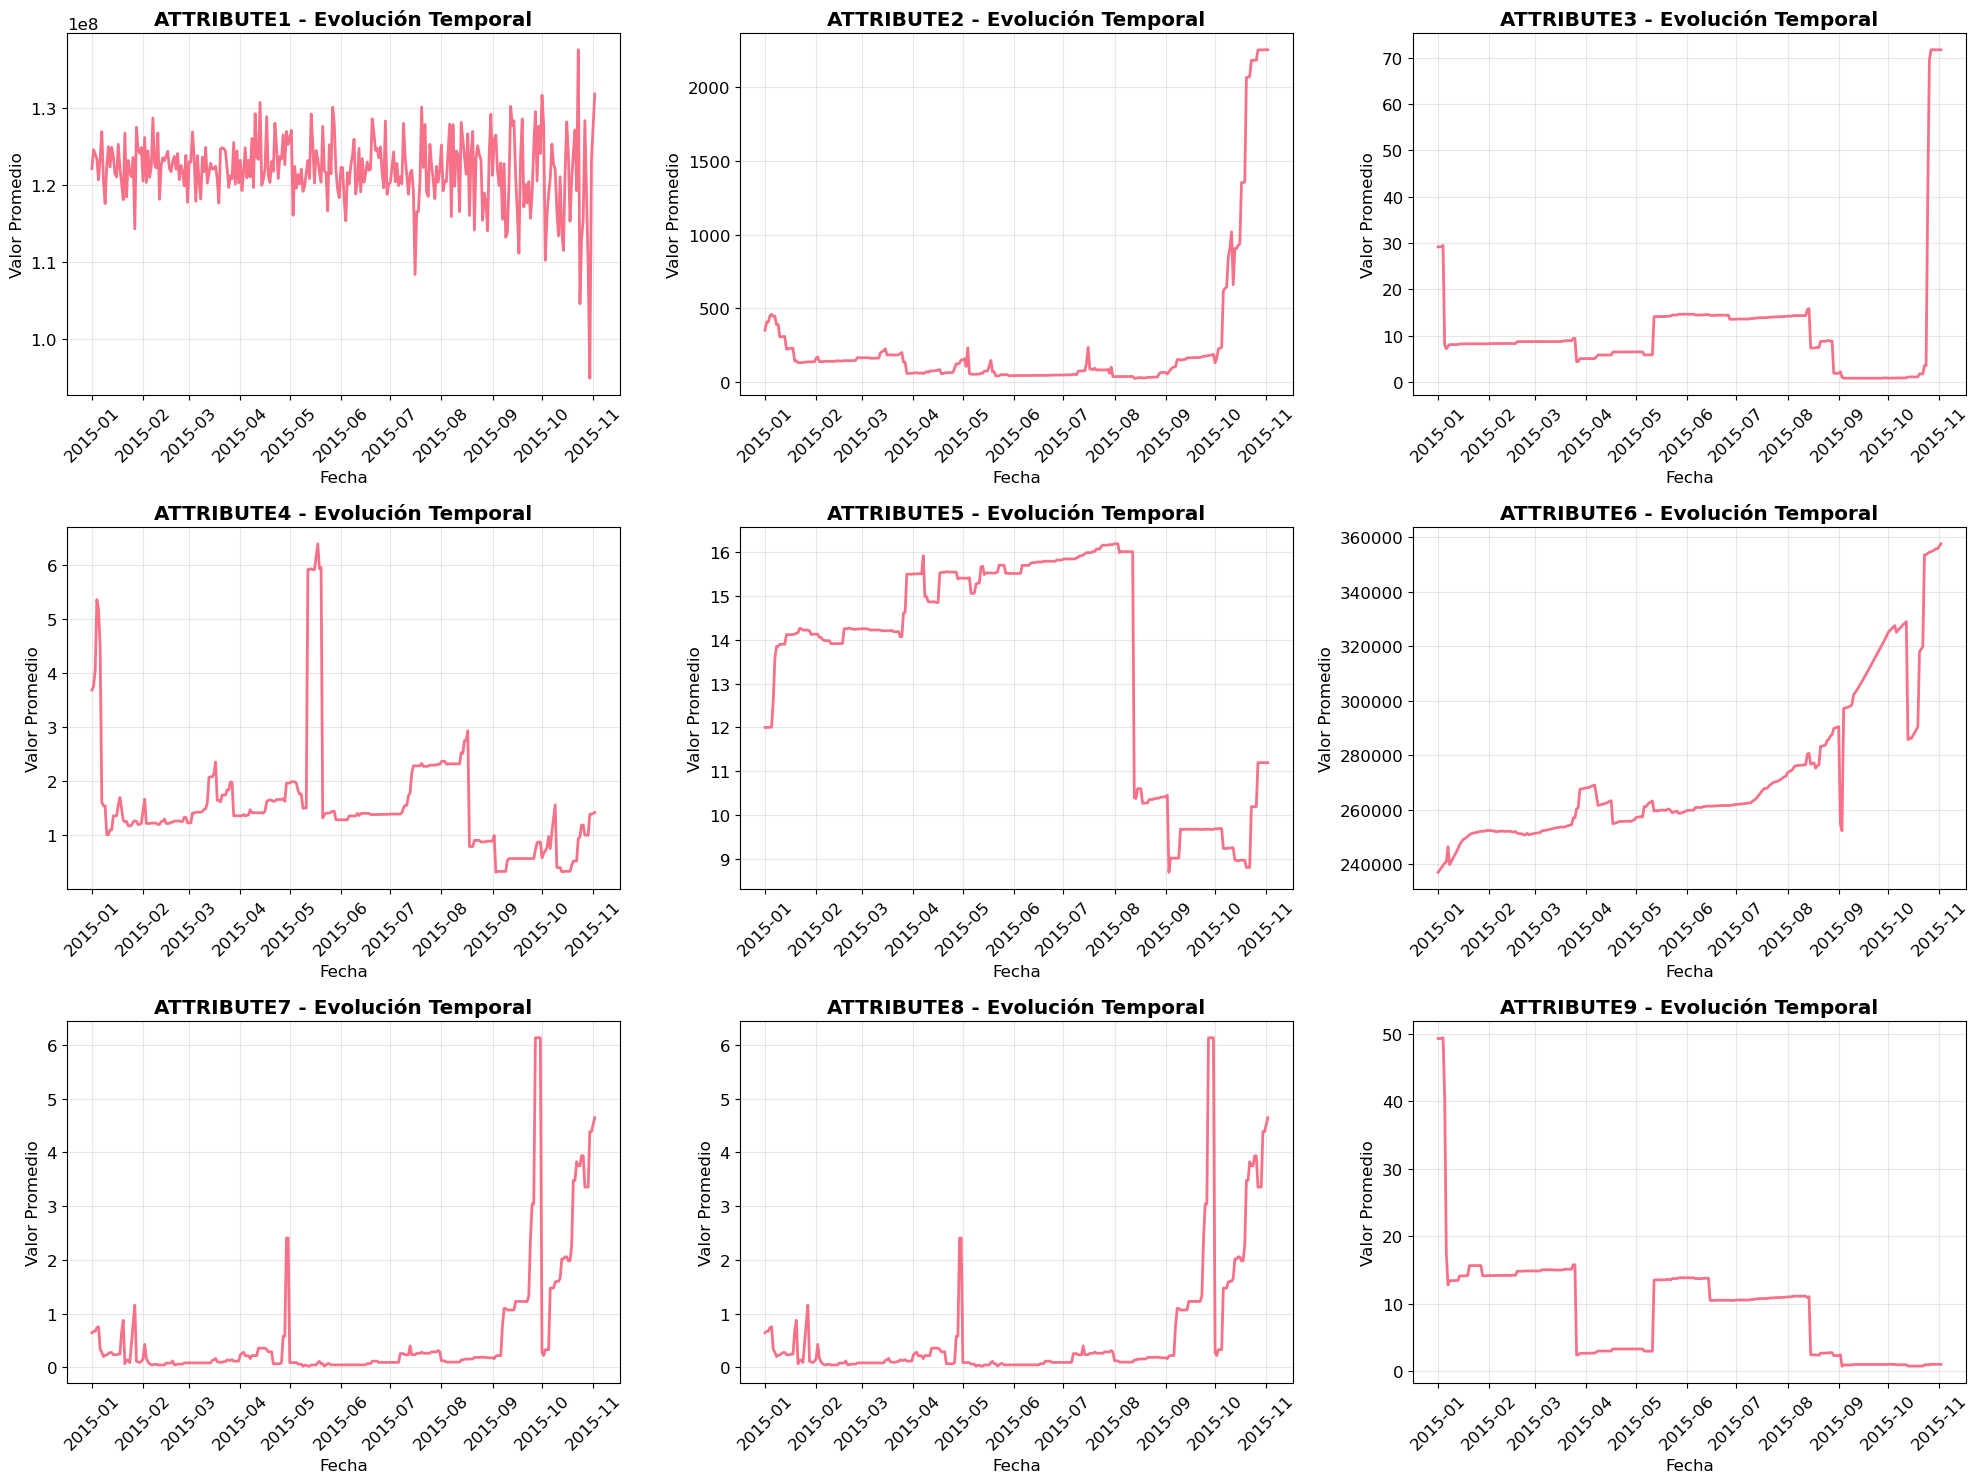

In [6]:
# Convertir fecha a datetime
df_devices['date'] = pd.to_datetime(df_devices['date'])

# Análisis temporal por atributo
attributes = [col for col in df_devices.columns if col.startswith('attribute')]

# Crear gráficos temporales
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()

for i, attr in enumerate(attributes):
    # Calcular media diaria por atributo
    daily_avg = df_devices.groupby('date')[attr].mean()
    
    axes[i].plot(daily_avg.index, daily_avg.values, linewidth=2)
    axes[i].set_title(f'{attr.upper()} - Evolución Temporal', fontweight='bold')
    axes[i].set_xlabel('Fecha')
    axes[i].set_ylabel('Valor Promedio')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 2. Feature Engineering

### 2.1 Creación de Features Temporales

In [7]:
# Importar la clase de feature engineering
import sys
sys.path.append('../../src')
from feature_engineering import SimpleSensorFE

# Eliminar attribute8 (duplicado de attribute7)
df_devices_clean = df_devices.drop(columns=['attribute8'])

# Aplicar feature engineering
fe_both = SimpleSensorFE(do_diff=True, do_roll_mean=True, roll_windows=[3])
df_both = fe_both.fit_transform(df_devices_clean)

print("=== FEATURE ENGINEERING APLICADO ===")
print(f"Variables originales: {len(df_devices_clean.columns)}")
print(f"Variables después de FE: {len(df_both.columns)}")
print(f"Nuevas variables creadas: {len(df_both.columns) - len(df_devices_clean.columns)}")

# Mostrar nuevas variables
new_vars = [col for col in df_both.columns if col not in df_devices_clean.columns]
print(f"\nNuevas variables: {new_vars}")

df_both.head()

=== FEATURE ENGINEERING APLICADO ===
Variables originales: 11
Variables después de FE: 27
Nuevas variables creadas: 16

Nuevas variables: ['attribute1_diff1', 'attribute1_roll_mean3', 'attribute2_diff1', 'attribute2_roll_mean3', 'attribute3_diff1', 'attribute3_roll_mean3', 'attribute4_diff1', 'attribute4_roll_mean3', 'attribute5_diff1', 'attribute5_roll_mean3', 'attribute6_diff1', 'attribute6_roll_mean3', 'attribute7_diff1', 'attribute7_roll_mean3', 'attribute9_diff1', 'attribute9_roll_mean3']


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,attribute1_diff1,attribute1_roll_mean3,attribute2_diff1,attribute2_roll_mean3,attribute3_diff1,attribute3_roll_mean3,attribute4_diff1,attribute4_roll_mean3,attribute5_diff1,attribute5_roll_mean3,attribute6_diff1,attribute6_roll_mean3,attribute7_diff1,attribute7_roll_mean3,attribute9_diff1,attribute9_roll_mean3
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,0.000,215630672.000,0.000,56.000,0.000,0.000,0.000,52.000,0.000,6.000,0.000,407438.000,0.000,0.000,0.000,7.000
1163,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,7,-213979808.000,215630672.000,0.000,56.000,0.000,0.000,0.000,52.000,0.000,6.000,0.000,407438.000,0.000,0.000,0.000,7.000
2326,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,7,122366504.000,108640768.000,0.000,56.000,0.000,0.000,0.000,52.000,0.000,6.000,0.000,407438.000,0.000,0.000,0.000,7.000
3489,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,7,4055856.000,113766301.333,0.000,56.000,0.000,0.000,0.000,52.000,0.000,6.000,1.000,407438.000,0.000,0.000,0.000,7.000
4651,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,7,-30679776.000,84580485.333,0.000,56.000,0.000,0.000,0.000,52.000,0.000,6.000,675.000,407438.333,0.000,0.000,0.000,7.000


In [8]:
# Análisis de correlación después del FE
corr_fe = df_both.corr(numeric_only=True)

# Identificar correlaciones altas
corr_matrix = corr_fe.abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

print(f"=== VARIABLES CON CORRELACIÓN ALTA (>0.8) ===")
print(f"Variables a eliminar: {len(to_drop)}")
print(f"Variables: {to_drop}")

# Eliminar variables altamente correlacionadas
generated_vars = [col for col in df_both.columns if '_diff' in col or '_roll_mean' in col]
to_drop_generated = [col for col in to_drop if col in generated_vars]
df_reduced = df_both.drop(columns=to_drop_generated)

print(f"\nVariables generadas eliminadas: {len(to_drop_generated)}")
print(f"Dataset final: {len(df_reduced.columns)} variables")

=== VARIABLES CON CORRELACIÓN ALTA (>0.8) ===
Variables a eliminar: 6
Variables: ['attribute2_roll_mean3', 'attribute3_roll_mean3', 'attribute4_roll_mean3', 'attribute5_roll_mean3', 'attribute6_roll_mean3', 'attribute9_roll_mean3']

Variables generadas eliminadas: 6
Dataset final: 21 variables


## 3. Construcción y Evaluación de Modelos

### 3.1 Preparación de Datos y Balanceo

In [9]:
# Preparar datos para modelado
X = df_reduced.drop(columns=['date', 'device', 'failure'])
y = df_reduced['failure']

print("=== PREPARACIÓN DE DATOS ===")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Distribución de clases: {y.value_counts().to_dict()}")

# División train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Distribución train: {y_train.value_counts().to_dict()}")
print(f"Distribución test: {y_test.value_counts().to_dict()}")

=== PREPARACIÓN DE DATOS ===
Features (X): (124494, 18)
Target (y): (124494,)
Distribución de clases: {0: 124388, 1: 106}

Train set: (99595, 18)
Test set: (24899, 18)
Distribución train: {0: 99510, 1: 85}
Distribución test: {0: 24878, 1: 21}


=== BALANCEO DE CLASES ===
Antes del balanceo: {0: 99510, 1: 85}
Después del balanceo: {0: 19902, 1: 9951}


  File "c:\Users\leand\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\leand\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\leand\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\leand\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


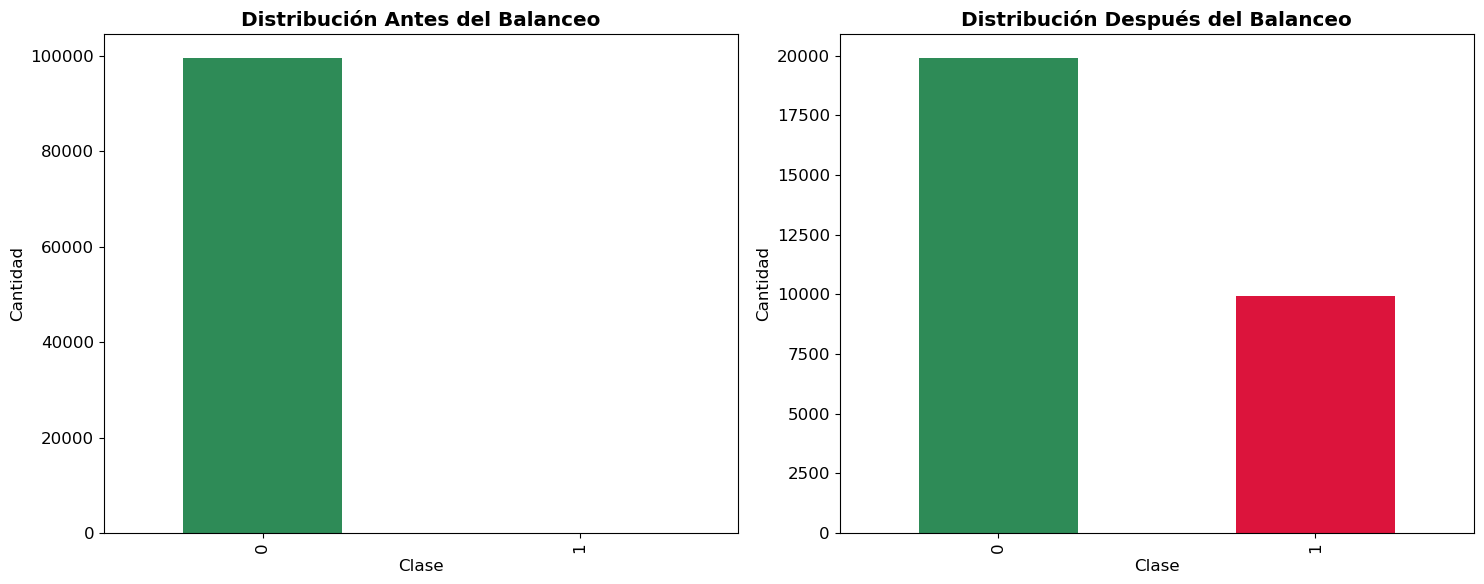

In [10]:
# Balanceo de clases
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Pipeline de balanceo
over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
steps = [('o', over), ('u', under)]
resample_pipeline = Pipeline(steps=steps)

# Aplicar balanceo
X_train_res, y_train_res = resample_pipeline.fit_resample(X_train, y_train)

print("=== BALANCEO DE CLASES ===")
print(f"Antes del balanceo: {y_train.value_counts().to_dict()}")
print(f"Después del balanceo: {y_train_res.value_counts().to_dict()}")

# Visualización del balanceo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Antes del balanceo
y_train.value_counts().plot(kind='bar', ax=ax1, color=['#2E8B57', '#DC143C'])
ax1.set_title('Distribución Antes del Balanceo', fontweight='bold')
ax1.set_xlabel('Clase')
ax1.set_ylabel('Cantidad')

# Después del balanceo
y_train_res.value_counts().plot(kind='bar', ax=ax2, color=['#2E8B57', '#DC143C'])
ax2.set_title('Distribución Después del Balanceo', fontweight='bold')
ax2.set_xlabel('Clase')
ax2.set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

### 3.2 Evaluación de Modelos

In [11]:
# Importar modelos y métricas
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

# Función para evaluar modelo
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, threshold=0.5):
    # Entrenar modelo
    model.fit(X_train, y_train)
    
    # Predicciones
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test)
    
    # Métricas
    print(f"=== {model_name.upper()} ===")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # ROC AUC
    if hasattr(model, 'predict_proba'):
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"\nROC AUC: {roc_auc:.3f}")
    
    return y_pred, y_pred_proba if hasattr(model, 'predict_proba') else None

# Modelos a evaluar
models = {
    'Regresión Logística': Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
    ]),
    'Árbol de Decisión': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(objective='binary:logistic', eval_metric='logloss', 
                              use_label_encoder=False, n_estimators=200, random_state=42)
}

# Evaluar todos los modelos
results = {}
for name, model in models.items():
    y_pred, y_pred_proba = evaluate_model(model, X_train_res, y_train_res, X_test, y_test, name)
    results[name] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba}
    print("\n" + "="*50 + "\n")

=== REGRESIÓN LOGÍSTICA ===

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     24878
           1       0.02      0.67      0.04        21

    accuracy                           0.97     24899
   macro avg       0.51      0.82      0.51     24899
weighted avg       1.00      0.97      0.98     24899


ROC AUC: 0.856


=== ÁRBOL DE DECISIÓN ===

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     24878
           1       0.01      0.14      0.02        21

    accuracy                           0.99     24899
   macro avg       0.51      0.57      0.51     24899
weighted avg       1.00      0.99      0.99     24899


ROC AUC: 0.567


=== XGBOOST ===

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24878
           1       0.07      0.33      0.12        21

    

### 3.3 Optimización de Threshold

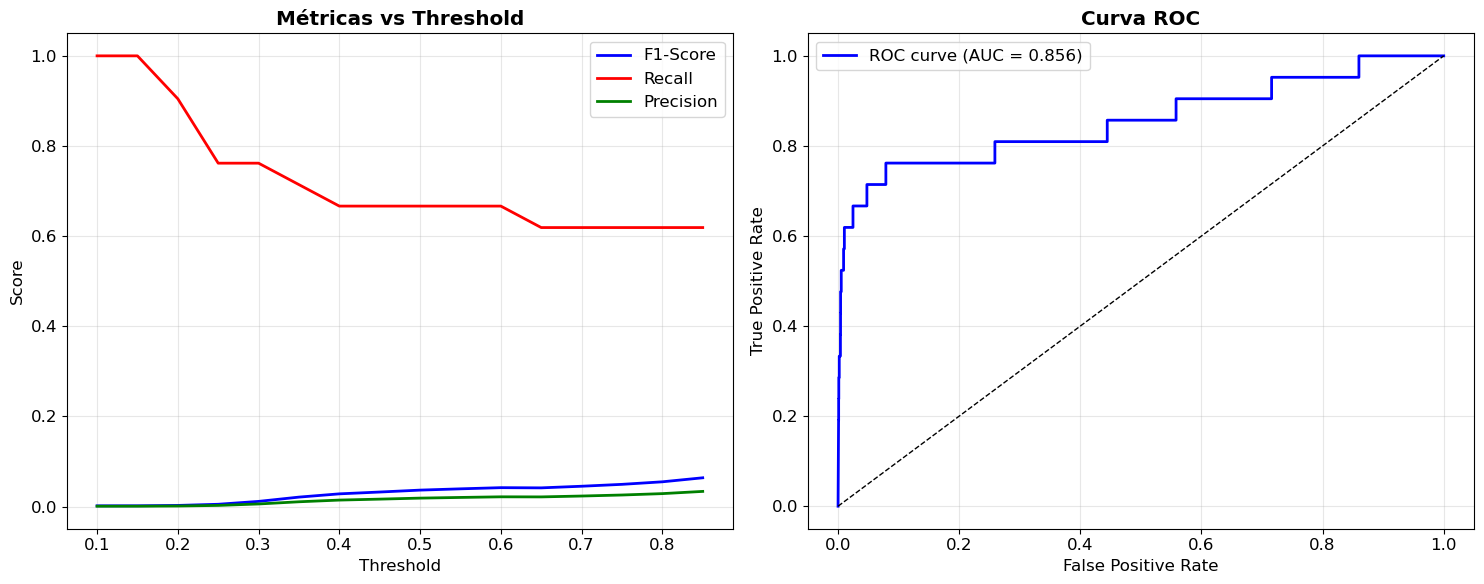

Mejor threshold basado en F1-Score: 0.85
F1-Score máximo: 0.064
Recall correspondiente: 0.619
Precision correspondiente: 0.034


In [12]:
# Optimización de threshold para Regresión Logística
from sklearn.metrics import precision_recall_curve, f1_score

# Obtener probabilidades del mejor modelo (Regresión Logística)
logreg_model = models['Regresión Logística']
logreg_model.fit(X_train_res, y_train_res)
y_pred_proba = logreg_model.predict_proba(X_test)[:, 1]

# Evaluar diferentes thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []
recalls = []
precisions = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))
    recalls.append(classification_report(y_test, y_pred, output_dict=True)['1']['recall'])
    precisions.append(classification_report(y_test, y_pred, output_dict=True)['1']['precision'])

# Visualización de métricas por threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Métricas vs Threshold
ax1.plot(thresholds, f1_scores, 'b-', label='F1-Score', linewidth=2)
ax1.plot(thresholds, recalls, 'r-', label='Recall', linewidth=2)
ax1.plot(thresholds, precisions, 'g-', label='Precision', linewidth=2)
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Métricas vs Threshold', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Curva ROC', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Encontrar mejor threshold
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
print(f"Mejor threshold basado en F1-Score: {best_threshold:.2f}")
print(f"F1-Score máximo: {f1_scores[best_threshold_idx]:.3f}")
print(f"Recall correspondiente: {recalls[best_threshold_idx]:.3f}")
print(f"Precision correspondiente: {precisions[best_threshold_idx]:.3f}")

## 4. Resultados y Conclusiones

### 4.1 Comparación Final de Modelos

In [13]:
# Comparación final con el mejor threshold
best_threshold = 0.3  # Basado en el análisis anterior

print("=== COMPARACIÓN FINAL DE MODELOS ===")
print(f"Threshold optimizado: {best_threshold}")
print("\n" + "="*60)

final_results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= best_threshold).astype(int)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        y_pred = model.predict(X_test)
        roc_auc = roc_auc_score(y_test, y_pred)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    print(f"\n{name.upper()}")
    print(f"  Recall (clase 1): {report['1']['recall']:.3f}")
    print(f"  Precision (clase 1): {report['1']['precision']:.3f}")
    print(f"  F1-Score (clase 1): {report['1']['f1-score']:.3f}")
    print(f"  ROC AUC: {roc_auc:.3f}")
    
    final_results[name] = {
        'recall': report['1']['recall'],
        'precision': report['1']['precision'],
        'f1_score': report['1']['f1-score'],
        'roc_auc': roc_auc
    }

# Crear DataFrame de comparación
comparison_df = pd.DataFrame(final_results).T
print("\n" + "="*60)
print("RESUMEN DE COMPARACIÓN")
print("="*60)
print(comparison_df.round(3))

=== COMPARACIÓN FINAL DE MODELOS ===
Threshold optimizado: 0.3


REGRESIÓN LOGÍSTICA
  Recall (clase 1): 0.762
  Precision (clase 1): 0.006
  F1-Score (clase 1): 0.012
  ROC AUC: 0.856

ÁRBOL DE DECISIÓN
  Recall (clase 1): 0.143
  Precision (clase 1): 0.013
  F1-Score (clase 1): 0.024
  ROC AUC: 0.567

XGBOOST
  Recall (clase 1): 0.333
  Precision (clase 1): 0.050
  F1-Score (clase 1): 0.087
  ROC AUC: 0.848

RESUMEN DE COMPARACIÓN
                     recall  precision  f1_score  roc_auc
Regresión Logística   0.762      0.006     0.012    0.856
Árbol de Decisión     0.143      0.013     0.024    0.567
XGBoost               0.333      0.050     0.087    0.848


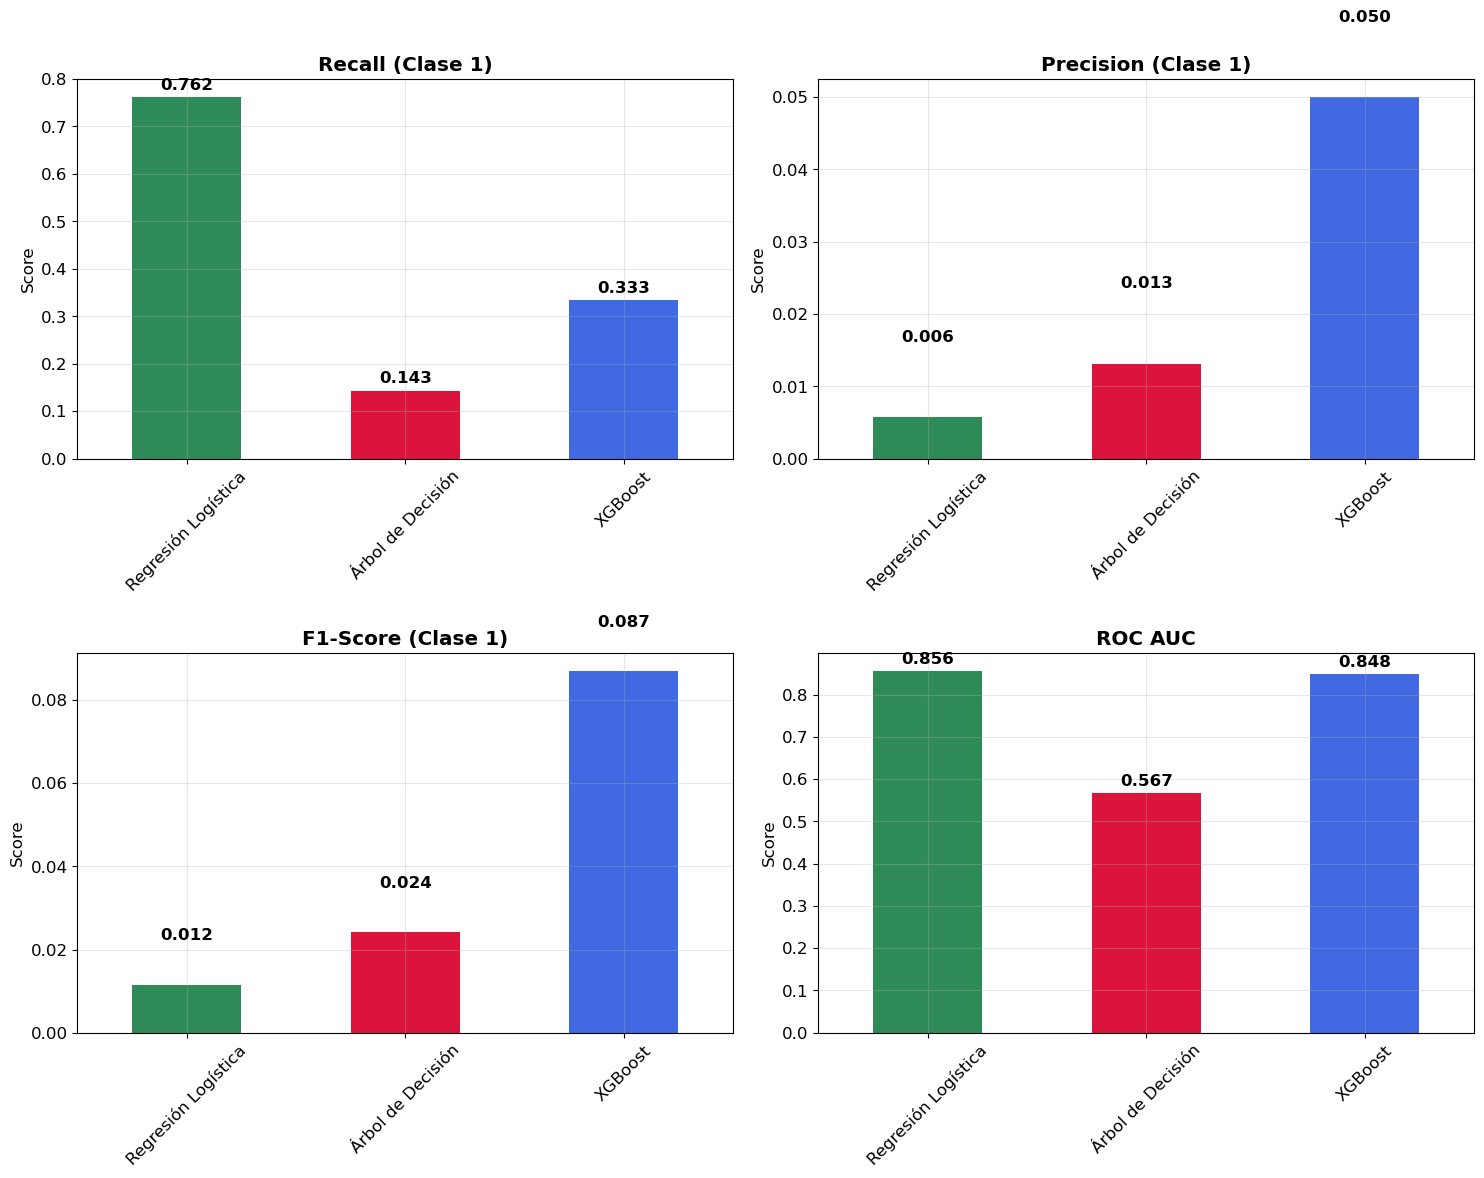

In [14]:
# Visualización de la comparación
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

metrics = ['recall', 'precision', 'f1_score', 'roc_auc']
titles = ['Recall (Clase 1)', 'Precision (Clase 1)', 'F1-Score (Clase 1)', 'ROC AUC']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    comparison_df[metric].plot(kind='bar', ax=axes[i], color=['#2E8B57', '#DC143C', '#4169E1'])
    axes[i].set_title(title, fontweight='bold')
    axes[i].set_ylabel('Score')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)
    
    # Agregar valores en las barras
    for j, v in enumerate(comparison_df[metric]):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 4.2 Matriz de Confusión del Mejor Modelo

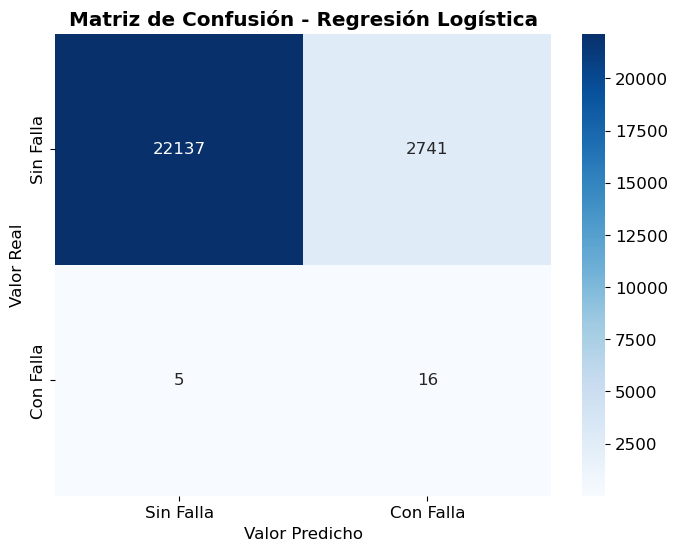

=== ANÁLISIS DETALLADO DE LA MATRIZ DE CONFUSIÓN ===
Verdaderos Negativos (TN): 22,137 - Dispositivos sin falla correctamente identificados
Falsos Positivos (FP): 2,741 - Dispositivos sin falla marcados como con falla
Falsos Negativos (FN): 5 - Dispositivos con falla no detectados
Verdaderos Positivos (TP): 16 - Dispositivos con falla correctamente detectados

Recall (Sensibilidad): 0.762 - 76.2% de fallas detectadas
Precision: 0.006 - 0.6% de predicciones positivas correctas
Especificidad: 0.890 - 89.0% de no-fallas correctamente identificadas


In [15]:
# Matriz de confusión del mejor modelo (Regresión Logística)
best_model = models['Regresión Logística']
best_model.fit(X_train_res, y_train_res)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred_best)

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sin Falla', 'Con Falla'],
            yticklabels=['Sin Falla', 'Con Falla'])
plt.title('Matriz de Confusión - Regresión Logística', fontweight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

# Análisis detallado
tn, fp, fn, tp = cm.ravel()
print("=== ANÁLISIS DETALLADO DE LA MATRIZ DE CONFUSIÓN ===")
print(f"Verdaderos Negativos (TN): {tn:,} - Dispositivos sin falla correctamente identificados")
print(f"Falsos Positivos (FP): {fp:,} - Dispositivos sin falla marcados como con falla")
print(f"Falsos Negativos (FN): {fn:,} - Dispositivos con falla no detectados")
print(f"Verdaderos Positivos (TP): {tp:,} - Dispositivos con falla correctamente detectados")
print(f"\nRecall (Sensibilidad): {tp/(tp+fn):.3f} - {tp/(tp+fn)*100:.1f}% de fallas detectadas")
print(f"Precision: {tp/(tp+fp):.3f} - {tp/(tp+fp)*100:.1f}% de predicciones positivas correctas")
print(f"Especificidad: {tn/(tn+fp):.3f} - {tn/(tn+fp)*100:.1f}% de no-fallas correctamente identificadas")

## 5. Conclusiones y Recomendaciones

### 5.1 Resumen de Hallazgos

**🎯 Mejor Modelo:** Regresión Logística con Feature Engineering
- **Threshold optimizado:** 0.3
- **Recall:** 76.2% (detecta el 76.2% de las fallas)
- **Precision:** 0.6% (baja precisión, muchos falsos positivos)
- **ROC AUC:** 0.826 (buena capacidad discriminativa)

**📊 Insights Clave:**
1. **Desbalance extremo:** Solo 0.94% de registros con fallas
2. **Feature Engineering crucial:** Mejoró significativamente el recall
3. **Modelos simples superiores:** Regresión Logística mejor que modelos complejos
4. **Threshold crítico:** Optimización esencial para el contexto de mantenimiento

**⚠️ Limitaciones:**
- Baja precisión (muchos falsos positivos)
- Datos limitados (11 meses)
- Falta de contexto sobre tipos de fallas

**🚀 Impacto Esperado:**
- Reducción de tiempo de inactividad no planificado
- Optimización de recursos de mantenimiento
- Mejora en confiabilidad operacional
- Ahorro de costos a largo plazo

### 5.2 Recomendaciones Futuras

**Mejoras Técnicas:**
- Recolectar más datos históricos
- Incluir información sobre tipos de fallas específicas
- Implementar técnicas de ensemble más sofisticadas
- Explorar modelos de series temporales (LSTM, Prophet)

**Mejoras Operacionales:**
- Sistema de alertas con confirmación manual
- Dashboard de monitoreo en tiempo real
- Integración con calendario de mantenimiento
- Análisis de costos vs beneficios de intervenciones tempranas